<a href="https://colab.research.google.com/github/zdwhite/Thinkful-Unit-2/blob/master/Challenge_Feedback_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/zdwhite/Thinkful-Unit-2/master/Sentiment%20Data%20Sets/yelp_labelled.txt"
            )
sms_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
sms_raw.columns = ['message', 'sentiment']

In [0]:
sms_raw

In [0]:
#before we tackle the NB model Let's get a sense of some key words

#Split
good_sentiment=sms_raw[sms_raw['sentiment']==1]['message'].apply(lambda x:x.split())

good_sentiment = pd.DataFrame(good_sentiment).apply(lambda x: pd.Series(x['message']),axis=1).stack().reset_index(level=1, drop=True).reset_index()

good_sentiment.columns=['Index','Words']

GSWC = pd.DataFrame(good_sentiment['Words'].value_counts().reset_index())
GSWC['sentiment']='Good'

bad_sentiment=sms_raw[sms_raw['sentiment']==0]['message'].apply(lambda x:x.split())

bad_sentiment = pd.DataFrame(bad_sentiment).apply(lambda x: pd.Series(x['message']),axis=1).stack().reset_index(level=1, drop=True).reset_index()

bad_sentiment.columns=['Index','Words']

bad_sentiment['Words'].value_counts()

BSWC = pd.DataFrame(bad_sentiment['Words'].value_counts().reset_index())
BSWC['sentiment']='Bad'

Bag_of_words=GSWC.append(BSWC)
Bag_of_words.columns=['Word','Count','Sentiment']

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


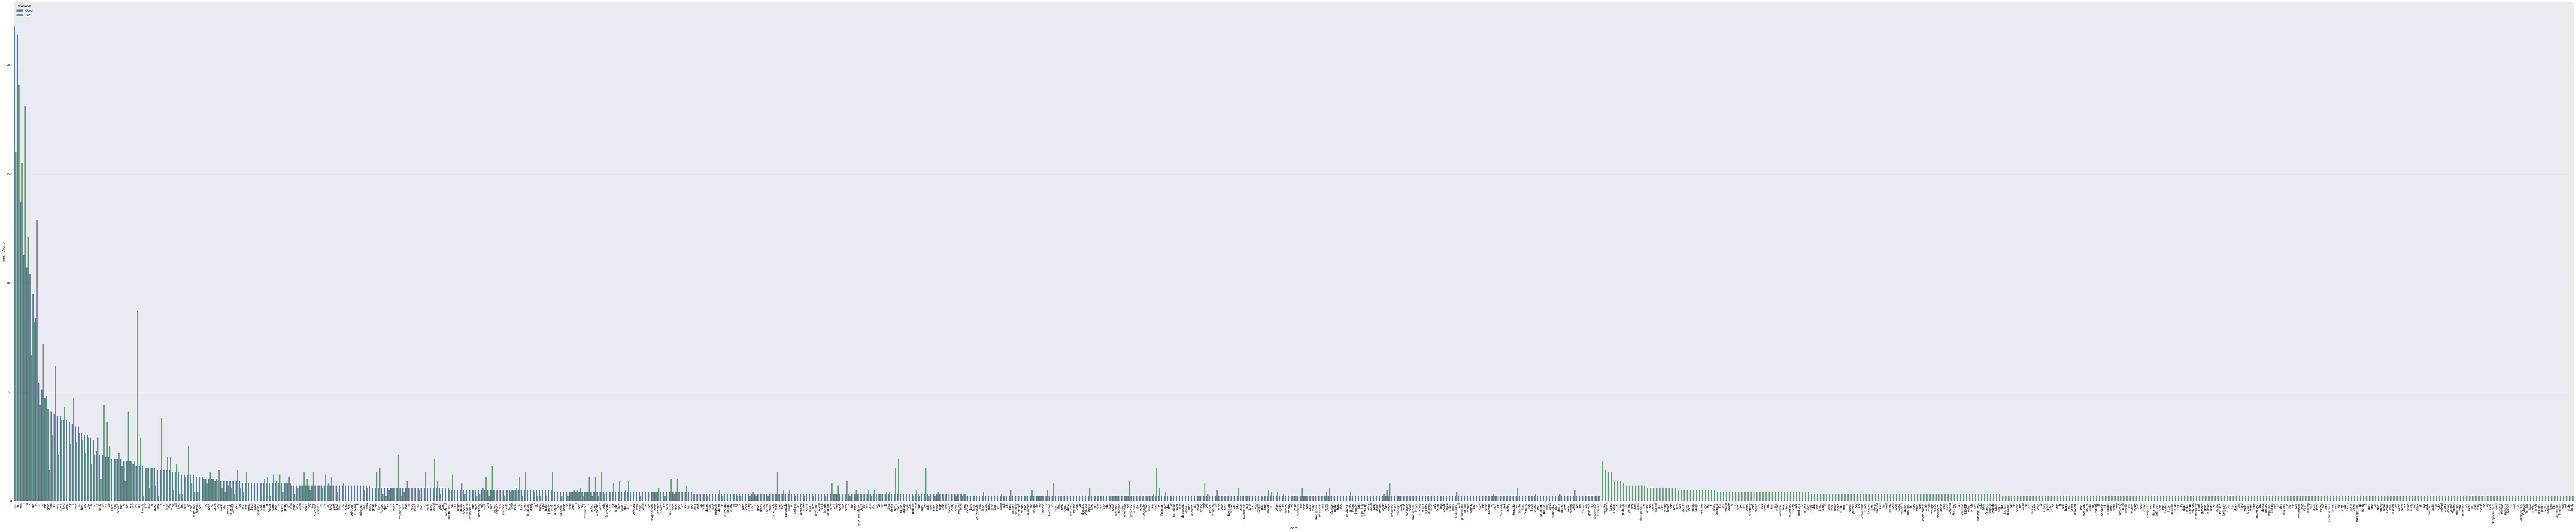

In [51]:
f, ax = plt.subplots(figsize=(150, 30))
ax.set_xticklabels(labels = Bag_of_words['Word'],rotation=90)
ax = sns.barplot(x='Word',y='Count',hue='Sentiment',data=Bag_of_words[Bag_of_words['Count']>1])

In [0]:
#for a word to be a keyword of bad sentiment let's assume that we choose all words that
#appear greater in frequency as bad sentiment by at least 1 STD from the the frequency